In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import io
from collections import defaultdict

### Stochastic Differential Equation for Hull White

$dr = \left( \theta(t) - a r(t) \right) dt + \sigma W(t)$

Discrete

$\Delta r = r(t_{i+1}) - r(t_{i}) = \left( \theta(t_{i}) - a r(t_{i}) \right) \left( t_{i+1} - t_{i} \right) + \sigma \left( W(t_{i+1}) - W(t_{i}) \right)$

### input parameter

In [354]:
a = 0.05
sigma = 0.01
delta_t = 0.25
h = 3
is_aprrox_m_v = 1

In [355]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

class Hull_White_binom_tree:
    def __init__(self, a, sigma, delta_t, h, is_approx_m_v):
        self._a = a
        self._sigma = sigma
        self._delta_t = delta_t
        self._h = h
        self._is_approx_m_v = is_approx_m_v
        self._M = - (self._a * self._delta_t)
        self._V = self._sigma ** 2 * self._delta_t
        self._jmax = int(np.ceil(- (1 - np.sqrt( 1 - 1 / self._h)) / self._M))
        self._len_ir = self._jmax * 2 + 1
    
    def calc_pu(self, j, tree_type):
        if tree_type == 0:
            return  (( 1/ self._h) + j ** 2 * self._M ** 2 + j * self._M ) / 2
        elif tree_type == -1:
            return  1 + 1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 + 3* j * self._M )
        elif tree_type == 1:
            return 1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 - j * self._M )
        
    def calc_pm(self, j, tree_type):
        if tree_type== 0:
            return  1 - 1 / self._h - j ** 2 * self._M ** 2
        elif tree_type == -1:
            return  - (( 1/ self._h) + j ** 2 * self._M ** 2 + 2 * j * self._M )
        elif tree_type == 1:
            return - (( 1/ self._h) + j ** 2 * self._M ** 2 - 2 * j * self._M )
        
    def calc_pd(self, j, tree_type):
        if tree_type == 0:
            return  1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 - j * self._M )
        elif tree_type == -1:
            return  1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 + j * self._M )
        elif tree_type == 1:
            return 1+ 1 / 2 * (( 1/ self._h) + j ** 2 * self._M ** 2 - 3 * j * self._M )
        
    def array_normal(self):
        return np.arange(- self._jmax + 1, self._jmax)
    
    def array_pu(self):
        array_pu = np.zeros(self._len_ir)
        array_pu[0] = self.calc_pu(- self._jmax, 1)
        array_pu[-1] = self.calc_pu(self._jmax, -1) 
        array_pu[1:-1] = self.calc_pu(self.array_normal(), 0)
        return array_pu
    
    def array_pm(self):
        array_pm = np.zeros(self._len_ir)
        array_pm[0] = self.calc_pm(- self._jmax, 1)
        array_pm[-1] = self.calc_pm(self._jmax, -1) 
        array_pm[1:-1] = self.calc_pm(self.array_normal(), 0)
        return array_pm
    
    def array_pd(self):
        array_pd = np.zeros(self._len_ir)
        array_pd[0] = self.calc_pd(- self._jmax, 1)
        array_pd[-1] = self.calc_pd(self._jmax, -1) 
        array_pd[1:-1] = self.calc_pd(self.array_normal(), 0)
        return array_pd
    
    def transition_prob(self):
        array_tran_prob = np.zeros(((self._jmax * 2 + 1), 4))
        array_tran_prob[:, 0] = np.arange(-self._jmax, self._jmax + 1)
        array_tran_prob[:, 1] = self.array_pu()
        array_tran_prob[:, 2] = self.array_pm()
        array_tran_prob[:, 3] = self.array_pd()
        return array_tran_prob[::-1]
    
    def transition_prob_df(self):
        tmp_df = pd.DataFrame(self.transition_prob(), columns=['index', 'Pu', 'Pm', 'Pd'])
        tmp_df['index'] = tmp_df['index'].astype(int)
        return tmp_df
    
    @property
    def a(self):
        return self._a
    
    @property
    def M(self):
        return self._M
    
    @property
    def V(self):
        return self._V
    
    @property
    def jmax(self):
        return self._jmax

In [356]:
tree_obj = Hull_White_binom_tree(a, sigma, delta_t, h, is_aprrox_M_V)
print(tree_obj.a)
print(tree_obj.V)
print(tree_obj.M)
print(tree_obj.jmax)
tree_obj.transition_prob_df().set_index('index')

0.05
2.5e-05
-0.0125
15


,Pu,Pm,Pd
index,,,
15,0.902995,0.006510,0.090495
14,0.094479,0.636042,0.269479
13,0.098620,0.640260,0.261120
12,0.102917,0.644167,0.252917
11,0.107370,0.647760,0.244870
10,0.111979,0.651042,0.236979
9,0.116745,0.654010,0.229245
8,0.121667,0.656667,0.221667
7,0.126745,0.659010,0.214245


In [397]:
txt = """
1.0
0.998360233
0.997047454
0.995728200
0.994227469
0.992416310
0.990090443
0.987984541
0.985438802
0.982069456
0.977639885
0.972136997
0.966008578
0.959495647
0.951990000
0.944242590
0.936095961
0.927614872
0.918849472
0.909738452
0.900521345
0.891235305
0.881616397
0.871915175
0.862283963
0.852768627
0.843099266
"""
ioo = io.StringIO(txt)
list_ois = list(map(lambda x: float(x), ioo.getvalue().split()))
list_date = np.arange(0, 6.75, 0.25)

In [401]:
df_ois = pd.DataFrame({'date': list_date, 'ois_discount': list_ois})
df_ois.head()

,date,ois_discount
0,0.00,1.000000
1,0.25,0.998360
2,0.50,0.997047
3,0.75,0.995728
4,1.00,0.994227


In [453]:
from collections import defaultdict
df_test = pd.DataFrame({'date': ['2018-07-31', '2019-07-31', '2018-07-31', '2019-07-31'], \
                        'values':[10, 30, 20, 40], \
                        'model': ['MODEL', 'MODEL', 'MODEL', 'MODEL'], \
                        'id':['1', '1', '2', '2']})
model_unmodel_list = ['MODEL', 'UNMODEL']
netset_list = ['1', '2']
dict_date = defaultdict(lambda: defaultdict(int))
for i in range(2):
    for j in range(2):
        df_test_ = df_test[(df_test['model'] == model_unmodel_list[i]) & (df_test['id'] == netset_list[j])]
        try:
            last_date = df_test_['date'].iloc[-1]
        except IndexError:
            print('index-error')
        else:
            dict_date[model_unmodel_list[i]][netset_list[j]] = last_date
dict_date

index-error
index-error


defaultdict(<function __main__.<lambda>>,
            {'MODEL': defaultdict(int,
                         {'1': '2019-07-31', '2': '2019-07-31'})})

In [6]:
df_test = pd.DataFrame({'date': ['2018-07-31', '2019-07-31', '2020-07-31', '2018-07-31', '2019-07-31'], \
                        'values':[10, 30, 20, 20, 40], \
                        'model': ['MODEL', 'MODEL', 'MODEL', 'MODEL', 'MODEL'], \
                        'id':['1', '1', '1', '2', '2']})

In [11]:
df_test.groupby('date').sum()

,values
date,
2018-07-31,30
2019-07-31,70
2020-07-31,20


In [21]:
np.random.rand(5) * 10

array([5.6298631 , 9.73702789, 0.36575975, 2.13668672, 4.87427057])

In [ ]:
trade_list = []
for i in range(20):
    str_trade = 'trade' + str(i)
    trade_list.append(str_trade)

In [27]:
df_test_2 = pd.DataFrame({'trade_num': trade_list,\
                          'pe0': np.random.rand(20) * 10,\
                         'mtm': np.random.randn(20)*5})

In [40]:
df_test_2['ratio'] = df_test_2['pe0'] / df_test_2['mtm']
df_test_2['labels'] = pd.cut(df_test_2['ratio'], bins=[-10, 0, 5, 10, 15, 20], labels=False)

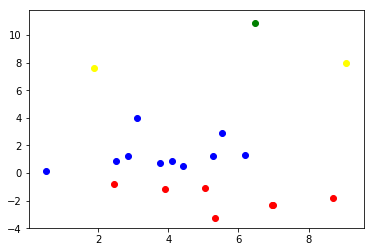

In [54]:
label_list = sorted(df_test_2['labels'].unique())
color_list = ['red', 'blue', 'yellow', 'green']
fig = plt.figure()
for i in range(len(label_list)):
    df_target = df_test_2[df_test_2['labels'] == label_list[i]]
    plt.scatter(df_target['pe0'], df_target['ratio'], color=color_list[i])